# Training

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from vae_based_medical_image_generator.data import dataset
from torch.utils.data import DataLoader, Dataset

Using downloaded and verified file: /home/leon/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/leon/.medmnist/chestmnist.npz


  0%|          | 0/50 [00:00<?, ?epochs/s]

Training:   0%|          | 0/1227 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/351 [00:00<?, ?batch/s]

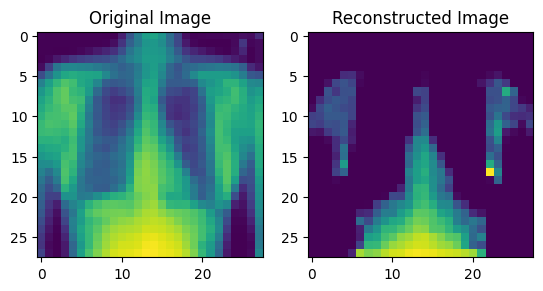

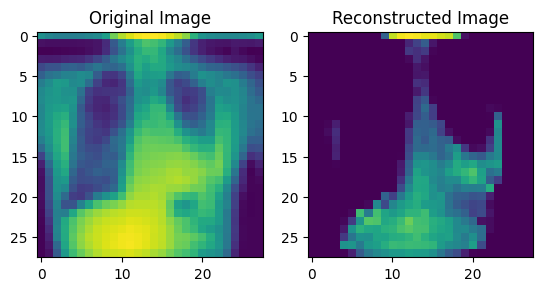

Training:   0%|          | 0/1227 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/351 [00:00<?, ?batch/s]

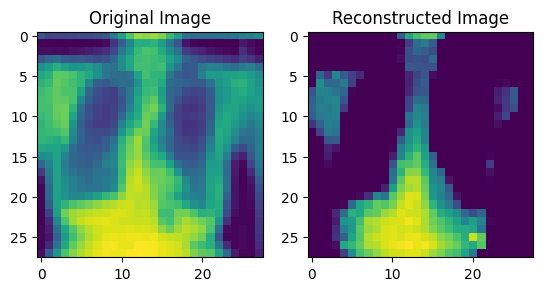

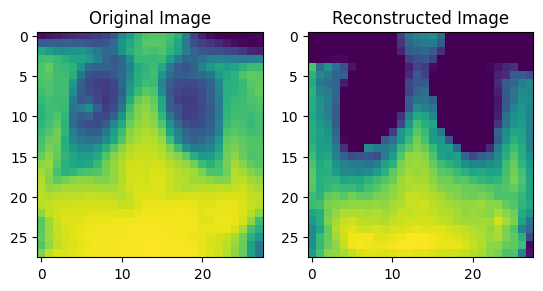

Training:   0%|          | 0/1227 [00:00<?, ?batch/s]

In [10]:
from tqdm.auto import trange, tqdm
from vae_based_medical_image_generator.model.vae import VariationalAutoencoder, vae_loss

def print_image(model: VariationalAutoencoder, dataset: Dataset, device: torch.device, sample_size: int = 1):
    model.eval()
    with torch.no_grad():
        for index in torch.randperm(len(dataset))[:sample_size]:
            image, _ = dataset[index]
            out, mu, logVAR = model(image.to(device).unsqueeze(1))

            plt.subplot(121)
            plt.imshow(image.numpy().squeeze())
            plt.title("Original Image")
            plt.subplot(122)
            plt.imshow(out.cpu().numpy().squeeze())
            plt.title("Reconstructed Image")
            plt.show()

def train(model: VariationalAutoencoder, train_dataloader: DataLoader, device: torch.device): 
    model.train()

    total_loss = 0
    pbar = tqdm(train_dataloader, unit="batch", desc="Training")
    for images, _ in pbar:
        images = images.to(device)

        optimizer.zero_grad()
            
        out, mu, logVar = model(images)
        training_loss = vae_loss(images, out, mu, logVar) 
        total_loss += training_loss.item()

        training_loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_dataloader.dataset)

def evaluate(model: VariationalAutoencoder, eval_dataloader: DataLoader, device: torch.device): 
    model.eval()
    total_loss = 0
    with torch.no_grad():
        pbar = tqdm(eval_dataloader, unit="batch", desc="Evaluating")
        for images, _ in pbar:
            images = images.to(device)

            out, mu, logVar = model(images)
            total_loss += vae_loss(images, out, mu, logVar).item()

    return total_loss / len(test_loader.dataset)

def fit(model: VariationalAutoencoder, train_dataloader: DataLoader, eval_dataloader: DataLoader, device: torch.device, predict_every: int = 1):
    training_losses = [] 
    test_losses = [] 

    pbar = trange(1, num_epochs + 1, unit="epochs")
    for epoch in range(1, num_epochs + 1):
        pbar.set_description(f"Epoch {epoch} of {num_epochs}, LR: {scheduler.get_last_lr()}")
        
        training_losses.append(train(model, train_dataloader, device))
        test_losses.append(evaluate(model, eval_dataloader, device))

        if epoch % predict_every == 0:
            print_image(model, train_loader.dataset, device)
            print_image(model, test_loader.dataset, device)

    return training_losses, test_losses


# Hyperparameters
batch_size = 64
lr = 1e-3
num_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae_model = VariationalAutoencoder(image_channels=1, latent_dimension=64, device=device).to(device)
# initialize dataset
train_dataset = dataset.load_dataset(dataset_name="chestmnist", split="train")
test_dataset  = dataset.load_dataset(dataset_name="chestmnist", split="test")

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# initialize optimizer and scheduler
optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader)*50, gamma=0.5, last_epoch=-1, verbose=False) 

train_losses, eval_losses = fit(vae_model, train_loader, test_loader, device)
# print_image(vae_model, train_loader.dataset, device)

# 14sek pro Batch

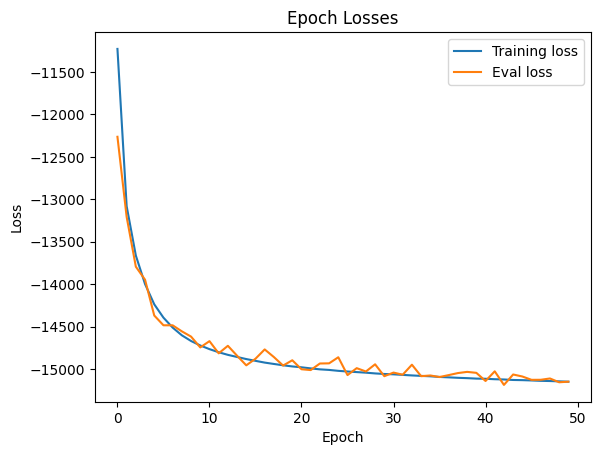

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = "Training loss")
plt.plot(eval_losses, label = "Eval loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses')
plt.legend()
plt.show()